In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import accuracy, error_rate

from gzip import GzipFile

In [3]:
image_path = Path('../image-data/04-stacked-rgb/')
image_path.ls()

[PosixPath('../image-data/04-stacked-rgb/high'),
 PosixPath('../image-data/04-stacked-rgb/medium'),
 PosixPath('../image-data/04-stacked-rgb/models'),
 PosixPath('../image-data/04-stacked-rgb/low')]

In [4]:
class ImageItemList_XChannel(ImageList):
    def open(self, fname):
        with GzipFile(fname, 'r') as in_file:
            np_image = np.load(in_file).astype(np.float32)/255        
        return Image(pil2tensor(np_image, np.float32).float())

In [5]:
image_size = 256
batch_size = 64
tfms = get_transforms()

In [6]:
data = (ImageItemList_XChannel.from_folder(image_path, extensions='.gz')
       .split_by_rand_pct()
       .label_from_folder()
       .transform(tfms, size=image_size)
       .databunch(bs=batch_size)
       .normalize()) # Optional

In [7]:
data

ImageDataBunch;

Train: LabelList (4709 items)
x: ImageItemList_XChannel
Image (6, 256, 256),Image (6, 256, 256),Image (6, 256, 256),Image (6, 256, 256),Image (6, 256, 256)
y: CategoryList
high,high,high,high,high
Path: ../image-data/04-stacked-rgb;

Valid: LabelList (1177 items)
x: ImageItemList_XChannel
Image (6, 256, 256),Image (6, 256, 256),Image (6, 256, 256),Image (6, 256, 256),Image (6, 256, 256)
y: CategoryList
high,high,low,medium,high
Path: ../image-data/04-stacked-rgb;

Test: None

In [8]:
data.classes, data.c

(['high', 'low', 'medium'], 3)

In [9]:
learn = cnn_learner(data, models.resnet34, metrics=[accuracy, error_rate], pretrained=False, callback_fns=ShowGraph)

In [10]:
learn.model[0][0] = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
learn.model.cuda();

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.931236,0.702993,0.644860,0.355140,00:33
1,0.751331,0.517197,0.742566,0.257434,00:32
2,0.609771,0.355594,0.850467,0.149533,00:32
3,0.473026,0.380795,0.822430,0.177570,00:31
4,0.384179,0.333621,0.834325,0.165675,00:32
5,0.292161,0.148126,0.934579,0.065421,00:31
6,0.237789,0.132172,0.947324,0.052676,00:32
7,0.190927,0.098468,0.961767,0.038233,00:35
8,0.144509,0.083146,0.966865,0.033135,00:33
9,0.135196,0.073071,0.967715,0.032285,00:31


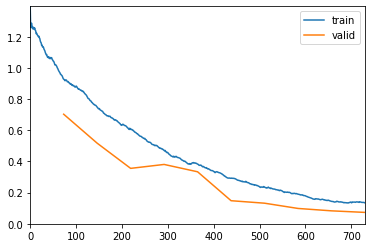

In [11]:
learn.fit_one_cycle(10)

In [21]:
learn.save('stage1-stacked-rgb')

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

losses, idxs = interp.top_losses()

len(data.valid_ds) == len(losses) == len(idxs)

True

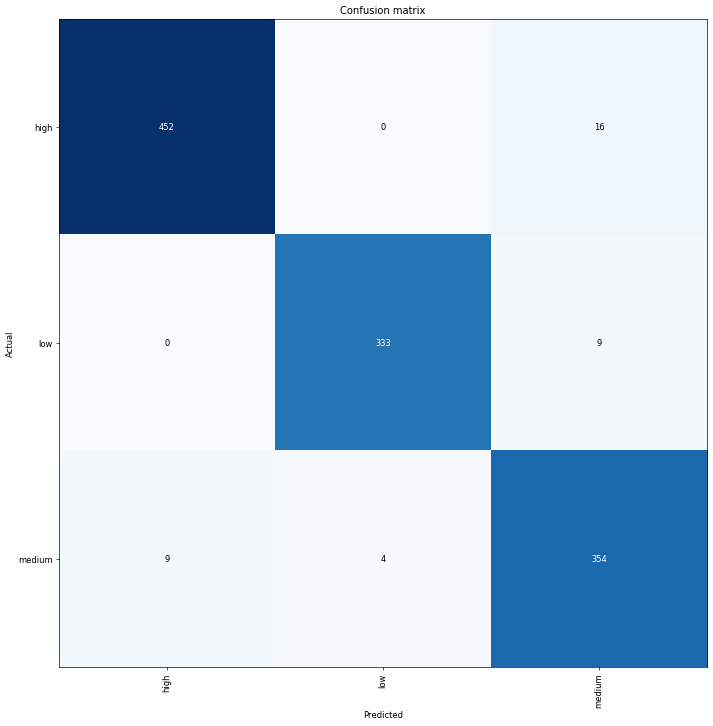

In [23]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [104]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


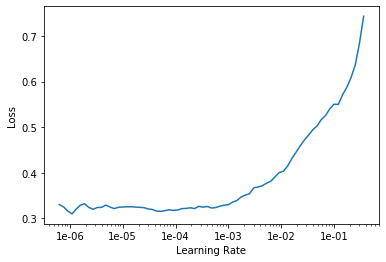

In [105]:
learn.recorder.plot()

In [15]:
from time import time

learn.load('stage1-stacked-rgb')
learn.model.training = False

grass_path = Path('../image-data/grass/4-stacked-rgb')

grass_path.ls()

[PosixPath('../image-data/grass/4-stacked-rgb/high'),
 PosixPath('../image-data/grass/4-stacked-rgb/medium'),
 PosixPath('../image-data/grass/4-stacked-rgb/low')]

In [19]:
# Doing this in a loop to get running times

def open_stacked(fname):
    with GzipFile(fname, 'r') as in_file:
        np_image = np.load(in_file).astype(np.float32)/255        
    return Image(pil2tensor(np_image, np.float32).float())

clsses = ['high', 'medium', 'low']
totals = [0, 0, 0]
correct = [0, 0, 0]

total_time = 0

for clss_idx, clss in enumerate(clsses):
    grass_fnames = grass_path/clss
    print(grass_fnames)
    for grass_fname in grass_fnames.glob('**/*.gz'):
        
        img = open_stacked(grass_fname)
        
        tstart = time()
        pred = learn.predict(img)
        total_time += time() - tstart
        
        if str(pred[0]) == clss:
            correct[clss_idx] += 1
        totals[clss_idx] += 1
print('done')

../image-data/grass/4-stacked-rgb/high
../image-data/grass/4-stacked-rgb/medium
../image-data/grass/4-stacked-rgb/low
done


In [20]:
print(correct)
print(totals)
print([c/t*100 for c, t in zip(correct, totals)])
print(sum(correct)/sum(totals)*100)
print(total_time)

[0, 0, 295]
[284, 295, 295]
[0.0, 0.0, 100.0]
33.75286041189931
8.032584428787231
